In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import geopandas as gpd
from shapely.geometry import Point
from scipy import stats
from sklearn.metrics import silhouette_score

# Load data
file_path = 'Cleaned_data_final.csv'
data = pd.read_csv(file_path)

# Convert date columns to datetime
data['Start date'] = pd.to_datetime(data['Start date'])
data['End date'] = pd.to_datetime(data['End date'])

# Extract hour from 'Start date' for filtering
data['start_hour'] = data['Start date'].dt.hour

# Filter trips to only include those that took place between 09:00-10:00 and 18:00-19:00
filtered_trips = data[(data['start_hour'] == 9) | (data['start_hour'] == 18)]

# Separate stations data (latitude and longitude) from trips data
stations_df = data[['Start station number', 'lat_start', 'lon_start']].drop_duplicates()
stations_df.columns = ['station_id', 'latitude', 'longitude']

# Trips data
trips_df = filtered_trips[['Bike number', 'Start station number', 'End station number', 'Total duration (ms)', 'start_hour']]
trips_df.columns = ['bike_number', 'start_station', 'end_station', 'trip_duration', 'start_hour']

# Merge trip data with station locations for start and end stations
trips_with_locations = trips_df.merge(stations_df, left_on='start_station', right_on='station_id', suffixes=('', '_start'))
trips_with_locations = trips_with_locations.merge(stations_df, left_on='end_station', right_on='station_id', suffixes=('', '_end'))

# Calculate trip counts and average trip duration for each station
trip_stats = trips_with_locations.groupby('start_station').agg({
    'trip_duration': ['count', 'mean']
}).reset_index()
trip_stats.columns = ['station_id', 'trip_count', 'avg_trip_duration']

# Merge with station locations
station_stats = stations_df.merge(trip_stats, on='station_id', how='left').fillna(0)

# Features for clustering
X = station_stats[['latitude', 'longitude']]


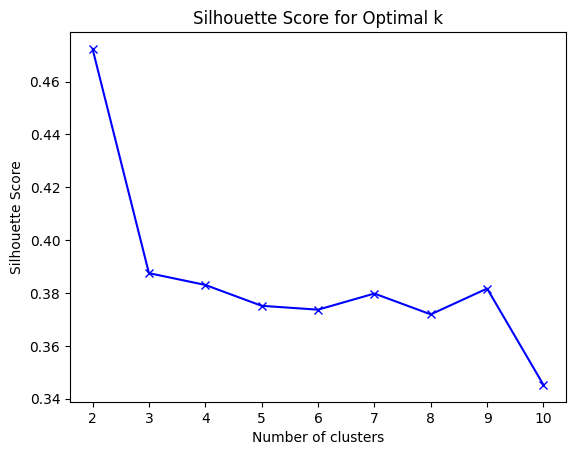

In [2]:
# Determine the optimal number of clusters using silhouette score
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()


In [3]:
# Apply K-Means clustering with the optimal number of clusters
optimal_k = 4  # Example value, determine from silhouette score
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
station_stats['cluster'] = kmeans.fit_predict(X)


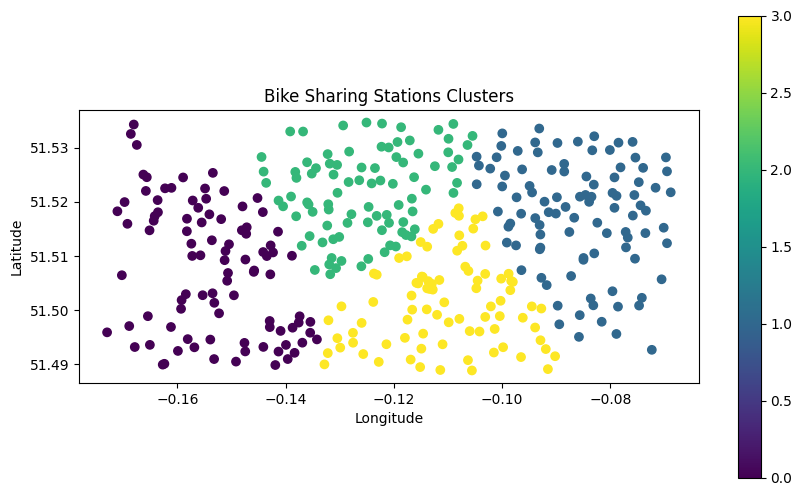

In [4]:
# Convert to GeoDataFrame for visualization
geometry = [Point(xy) for xy in zip(station_stats['longitude'], station_stats['latitude'])]
gdf = gpd.GeoDataFrame(station_stats, geometry=geometry)

# Plot clusters
gdf.plot(column='cluster', cmap='viridis', legend=True, figsize=(10, 6))
plt.title('Bike Sharing Stations Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [6]:
# Find stations that are outliers in trip counts within each cluster
from scipy import stats
import pandas as pd
from IPython.display import display, HTML

# Calculate z-scores for trip_count within each cluster
station_stats['trip_count_zscore'] = station_stats.groupby('cluster')['trip_count'].transform(lambda x: stats.zscore(x))

# Identify outliers based on z-score threshold
outliers = station_stats[station_stats['trip_count_zscore'].abs() > 2]

# Calculate the average trip count for each cluster
cluster_avg_trip_count = station_stats.groupby('cluster')['trip_count'].mean().reset_index()
cluster_avg_trip_count.columns = ['cluster', 'avg_trip_count']

# Merge the average trip count information with the outliers
outliers = outliers.merge(cluster_avg_trip_count, on='cluster', how='left')

# Display the outliers with the average trip count of their clusters
display(HTML(outliers.to_html(index=False)))


station_id,latitude,longitude,trip_count,avg_trip_duration,cluster,trip_count_zscore,avg_trip_count
300083,51.506304,-0.087262,909,707089.863586,1,2.191210,399.288660
2587,51.516154,-0.082422,1342,741461.066319,1,4.052643,399.288660
1067,51.507424,-0.134621,716,816838.995810,2,2.781188,327.235955
200246,51.533560,-0.093150,948,683077.532700,1,2.358868,399.288660
1035,51.522511,-0.162298,667,926727.148426,0,3.530322,227.595745
1052,51.515631,-0.132328,688,744793.760174,2,2.580878,327.235955
968,51.497998,-0.142960,522,866537.141762,0,2.365343,227.595745
995,51.514499,-0.141423,555,812514.400000,0,2.630476,227.595745
980,51.521680,-0.130431,659,742574.415781,2,2.373414,327.235955
1090,51.524438,-0.138019,617,622069.038898,2,2.072949,327.235955
